### **1. Load Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.auto import tqdm
from IPython.display import display, HTML
from scipy.stats import norm, beta
sns.set()
plt.style.use('seaborn-poster')

home = pd.read_csv('property.csv')
display(home.head())

print(home.shape)

<ipython-input-2-d00cab861777>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


,item_id,deposit,monthly_rent,district_uuid,room_qty,unit_area,has_elevator,building_floor_count,unit_floor,has_storage_area,property_age
0,91c0e569-bddd-4128-9720-2550bb85580e,64800000.0,0,263682f6-d0cd-4569-aeec-e727b76b7665,1.0,42,False,3.0,0.0,True,23.0
1,b00b7919-06be-4d26-98b8-1971787e1d46,72000000.0,4320000,97c9535e-3985-47ce-a84c-a962c838a76b,2.0,116,True,NaN,1.0,True,16.0
2,9eddb6bc-e424-4774-b55f-bfd54366d627,50400000.0,1440000,b790f536-c274-4147-86e0-94d9b6d7352d,1.0,74,False,2.0,0.0,True,19.0
3,12cf6b07-5d56-4126-94d2-ce9cbfe2214f,36000000.0,864000,93d06676-4975-4cc5-919b-3a0c29c7ad43,1.0,60,True,NaN,2.0,False,6.0
4,929eb20c-3694-46b2-b96c-91117b995d1b,28800000.0,1296000,58e59fa9-9947-478f-9cef-bc6a2cbe49a9,1.0,45,True,NaN,1.0,True,4.0


(4930, 11)


### **2. Preporocessing**

Drop Nan and creating new df clean_home

In [ ]:
clean_home = (home
              .loc[~((home['unit_area'] == 0)|(home['room_qty'] == 0))]
              .dropna(subset=['district_uuid',
                              'room_qty',
                              'property_age',
                              'deposit',
                              'has_storage_area',
                              'has_elevator',
                              'unit_floor'])
             )


In [ ]:
# Assuming 'clean_home' is your DataFrame
clean_home = pd.get_dummies(clean_home, columns=['has_elevator', 'has_storage_area'], drop_first=True)


In [ ]:
!pip install fancyimpute


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=a389d4afd82cc58629b9745d4642bf350d6f94cca31801e874b6bdd3c5790039
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=c92f938933a776b1a13ea561a6b8d23ab8dc352e8e83d46eb0bc8781e0a559bf
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


Using KNN to Impute building_floor_count

In [ ]:
import fancyimpute
# select only numrical columns
X = clean_home[[c for c in clean_home.columns if c not in ['item_id','district_uuid']]].copy()

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = fancyimpute.KNN(k=3).fit_transform(X)

# round the number
clean_home['imputing_building_floor_count'] = X_filled_knn[:,5]

Imputing row 1/4783 with 0 missing, elapsed time: 7.036
Imputing row 101/4783 with 0 missing, elapsed time: 7.062
Imputing row 201/4783 with 0 missing, elapsed time: 7.069
Imputing row 301/4783 with 1 missing, elapsed time: 7.079
Imputing row 401/4783 with 1 missing, elapsed time: 7.085
Imputing row 501/4783 with 0 missing, elapsed time: 7.088
Imputing row 601/4783 with 1 missing, elapsed time: 7.092
Imputing row 701/4783 with 0 missing, elapsed time: 7.104
Imputing row 801/4783 with 1 missing, elapsed time: 7.123
Imputing row 901/4783 with 1 missing, elapsed time: 7.127
Imputing row 1001/4783 with 1 missing, elapsed time: 7.141
Imputing row 1101/4783 with 0 missing, elapsed time: 7.167
Imputing row 1201/4783 with 1 missing, elapsed time: 7.171
Imputing row 1301/4783 with 0 missing, elapsed time: 7.186
Imputing row 1401/4783 with 0 missing, elapsed time: 7.190
Imputing row 1501/4783 with 0 missing, elapsed time: 7.193
Imputing row 1601/4783 with 0 missing, elapsed time: 7.197
Imputing 

### **Categorize Features ( Feature Engineering)**
convert every feature to categorical features as interval bin

In [ ]:
import math
from pandas.api.types import CategoricalDtype

# Assuming 'clean_home' is your DataFrame

# Binning for 'unit_area'
bins = [0, 50, 100, 150, float('inf')]
labels = ['Small', 'Medium', 'Large', 'Extra Large']
clean_home['unit_area_category'] = pd.cut(clean_home['unit_area'], bins=bins, labels=labels, right=False).astype(str)

# Binning for 'property_age'
age_bins = [0, 10, 20, 30, 40, 50, float('inf')]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
clean_home['property_age_category'] = pd.cut(clean_home['property_age'], bins=age_bins, labels=age_labels, right=False).astype(str)

# Convert categorical columns to CategoricalDtype
category_columns = ['unit_area_category', 'property_age_category']
for col in category_columns:
    clean_home[col] = clean_home[col].astype(CategoricalDtype())

# Display the updated DataFrame
display(clean_home.head())


,item_id,deposit,monthly_rent,district_uuid,room_qty,unit_area,building_floor_count,unit_floor,property_age,has_elevator_True,has_storage_area_True,imputing_building_floor_count,unit_area_category,property_age_category
0,91c0e569-bddd-4128-9720-2550bb85580e,64800000.0,0,263682f6-d0cd-4569-aeec-e727b76b7665,1.0,42,3.0,0.0,23.0,0,1,0.0,Small,21-30
1,b00b7919-06be-4d26-98b8-1971787e1d46,72000000.0,4320000,97c9535e-3985-47ce-a84c-a962c838a76b,2.0,116,NaN,1.0,16.0,1,1,1.0,Large,11-20
2,9eddb6bc-e424-4774-b55f-bfd54366d627,50400000.0,1440000,b790f536-c274-4147-86e0-94d9b6d7352d,1.0,74,2.0,0.0,19.0,0,1,0.0,Medium,11-20
3,12cf6b07-5d56-4126-94d2-ce9cbfe2214f,36000000.0,864000,93d06676-4975-4cc5-919b-3a0c29c7ad43,1.0,60,NaN,2.0,6.0,1,0,2.0,Medium,0-10
4,929eb20c-3694-46b2-b96c-91117b995d1b,28800000.0,1296000,58e59fa9-9947-478f-9cef-bc6a2cbe49a9,1.0,45,NaN,1.0,4.0,1,1,1.0,Small,0-10


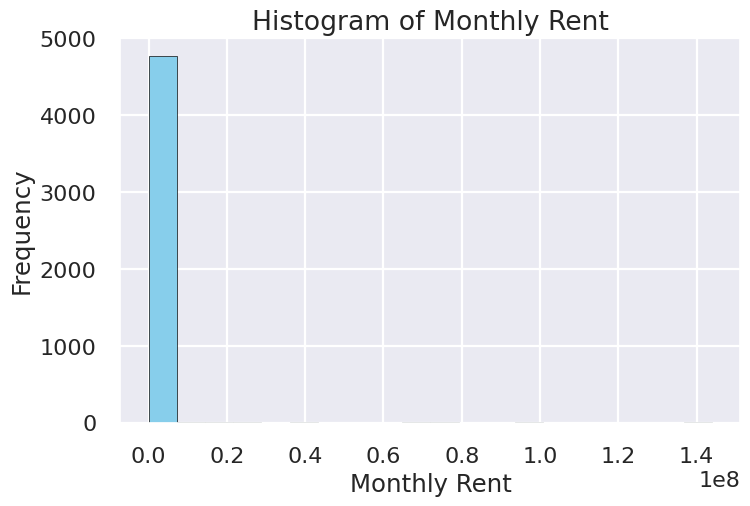

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(clean_home['monthly_rent'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Monthly Rent')
plt.xlabel('Monthly Rent')
plt.ylabel('Frequency')
plt.show()


<ipython-input-20-46cb4c59a1e3>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = clean_home.corr()


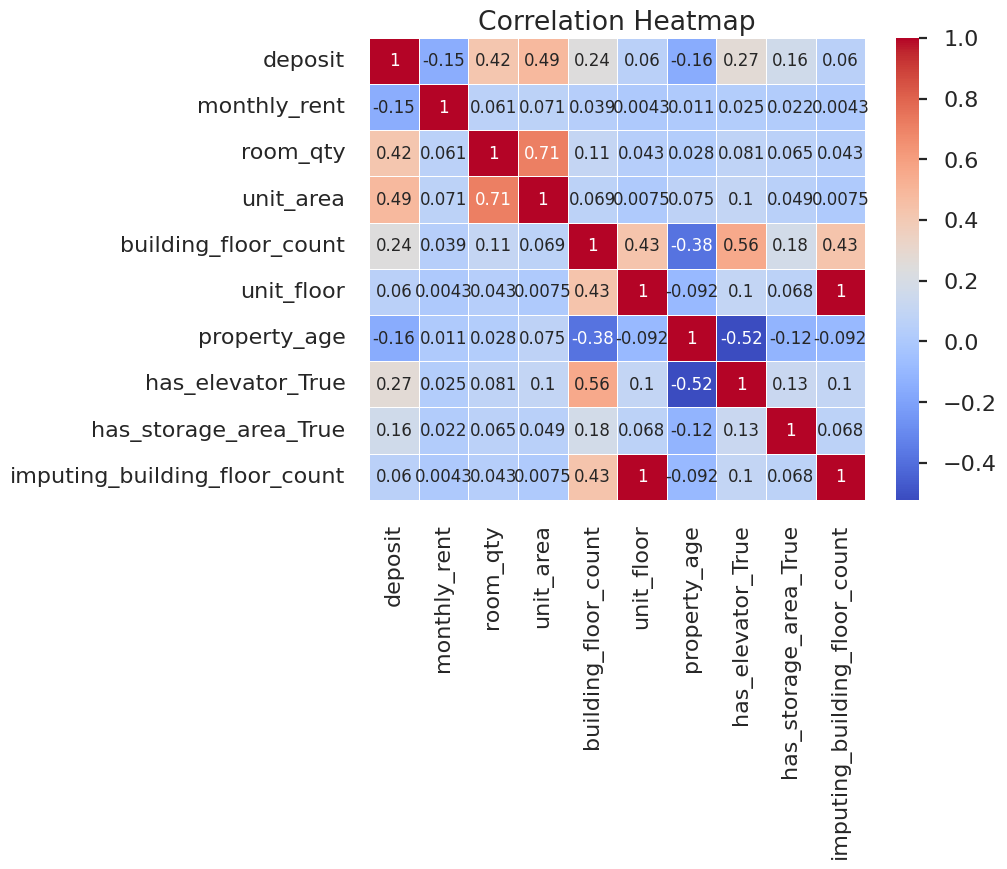

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
corr_matrix = clean_home.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


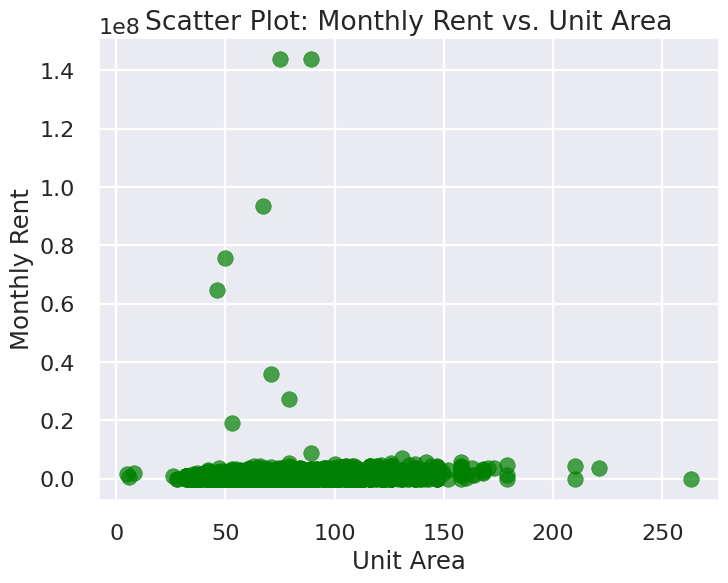

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(clean_home['unit_area'], clean_home['monthly_rent'], color='green', alpha=0.7)
plt.title('Scatter Plot: Monthly Rent vs. Unit Area')
plt.xlabel('Unit Area')
plt.ylabel('Monthly Rent')
plt.show()


<ipython-input-22-aa0b2b8cbf4f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='room_qty', data=clean_home, palette='viridis')


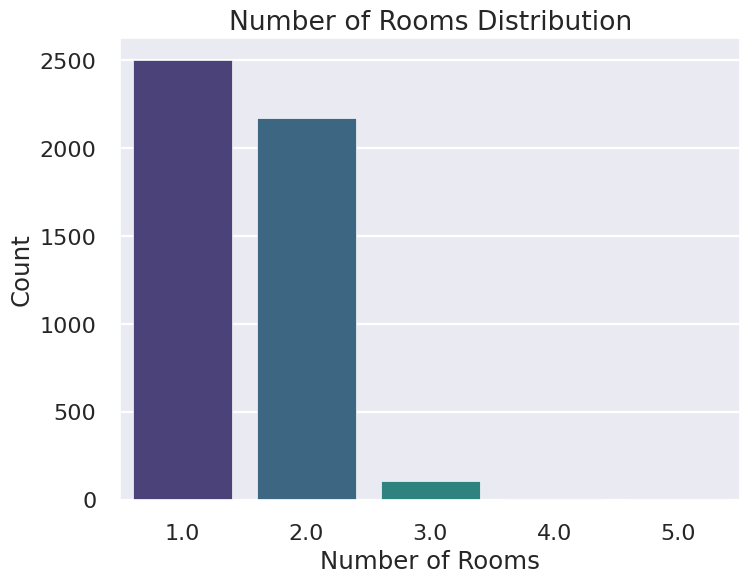

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='room_qty', data=clean_home, palette='viridis')
plt.title('Number of Rooms Distribution')
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.show()


<ipython-input-18-57f58cfa287b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unit_area_category', y='property_age', data=clean_home, palette='muted')


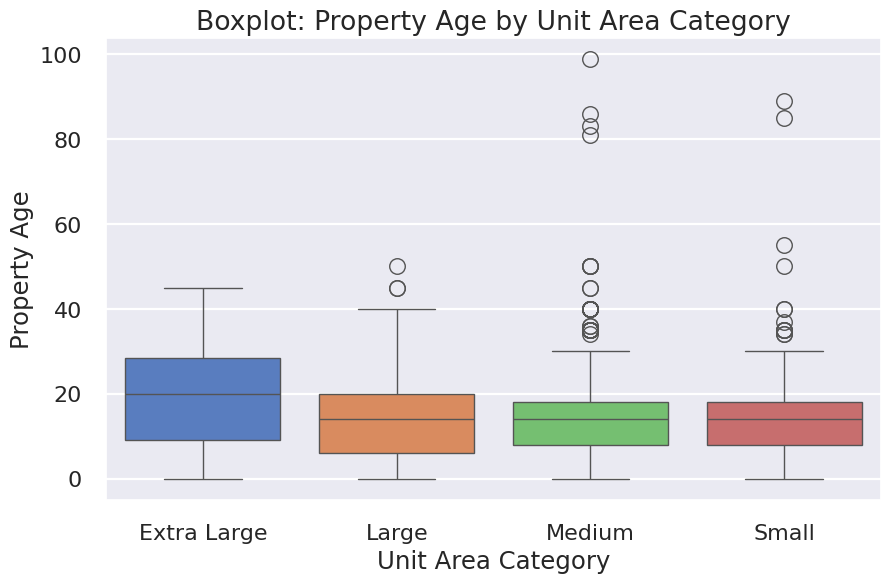

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='unit_area_category', y='property_age', data=clean_home, palette='muted')
plt.title('Boxplot: Property Age by Unit Area Category')
plt.xlabel('Unit Area Category')
plt.ylabel('Property Age')
plt.show()
